# Redshift: column value distribution

## setup

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import db_diff as db

In [12]:
def connect():
    config = db.load_config('../../etc/prod-ostro/aws.json')
    engine = db.rs_connect('ostro', config)
    conn = engine.connect()
    conn.execute("SET search_path TO leviathan")
    return conn

## sql functions

In [13]:
def create_base(table_id, column_name, timestamp='timestamp'):
    return """
    derived_base AS (
        SELECT
            to_char("{timestamp}", 'YYYYMMDD') as event_day,
            extract(hour from "{timestamp}") as event_hour,
            {column} AS event_column
        FROM {table}
        WHERE date("{timestamp}") BETWEEN '2017-09-04' AND '2017-10-05'
        AND test = false
        )
    """.format(table=table_id, column=column_name, timestamp=timestamp)

In [14]:
def create_base_percentile(table_id, column_name, timestamp='timestamp'):
    return """
    outlier_percentiles AS (
        SELECT
            percentile_cont(0.05) within group (order by {column}) as ptile_lower,
            percentile_cont(0.95) within group (order by {column}) as ptile_upper
        FROM {table}
        ),
    
    derived_base AS (
        SELECT
            to_char("{timestamp}", 'YYYYMMDD') as event_day,
            extract(hour from "{timestamp}") as event_hour,
            {column} AS event_column
        FROM {table}
        WHERE date("{timestamp}") BETWEEN '2017-09-04' AND '2017-10-05'
        AND test = false
        AND {column} > (SELECT ptile_lower FROM outlier_percentiles)
        AND {column} < (SELECT ptile_upper FROM outlier_percentiles)
        )
    """.format(table=table_id, column=column_name, timestamp=timestamp)

In [15]:
def create_bool_convert():
    return """
    derived_number AS (
        SELECT
            event_day,
            event_hour,
            CASE event_column
            WHEN true  THEN 0.75
            WHEN false THEN 0.25
            END AS number_column
        FROM derived_base
        )
    """

In [16]:
def create_time_convert():
    return """
    derived_number AS (
        SELECT
            event_day,
            event_hour,
            extract(epoch from event_column) AS number_column
        FROM derived_base
        )
    """

In [17]:
def create_number_convert():
    return """
    derived_number AS (
        SELECT
            event_day,
            event_hour,
            event_column AS number_column
        FROM derived_base
        )
    """

In [18]:
def create_string_convert(slice_size=5):
    if slice_size >= 0:
        substr_parameters = "event_column,0,{no_characters}".format(no_characters=slice_size)
    else:
        substr_parameters = "reverse(event_column),0,{no_characters}".format(no_characters=(-1*slice_size))

    return """
    string_substr AS (
        SELECT
            event_day,
            event_hour,
            SUBSTRING({parameters}) AS string_column
        FROM derived_base
        ),

    derived_number AS (
        SELECT
            event_day,
            event_hour,
            STRTOL(SUBSTRING(MD5(string_column),0,15), 16) AS number_column
        FROM string_substr
        )
    """.format(parameters=substr_parameters)

In [19]:
def create_hash_convert():
    return """
    derived_number AS (
        SELECT
            event_day,
            event_hour,
            STRTOL(SUBSTRING(event_column,0,15), 16) AS number_column
        FROM derived_base
        WHERE regexp_count(event_column, '[ABCDEF0123456789]') = length(event_column)
        )
    """

In [20]:
def create_normalized():
    return """
    derived_stats AS (
        SELECT
            min(number_column) AS min_value,
            max(number_column) AS max_value,
            max(number_column) - min(number_column) AS range_value,
            median(number_column) AS mean_value
        FROM derived_number
        WHERE number_column > 0
        ),

    derived_norm AS (
        SELECT
            event_day,
            event_hour,
            number_column as raw_value,
            (number_column::float - (SELECT min_value from derived_stats))
                / (SELECT range_value from derived_stats)
            AS normed_value
        FROM derived_number
        )
    """

In [21]:
def create_normed(sql_with):
    return """
    WITH
    {sql_with}

    SELECT
        event_day,
        event_hour,
        raw_value,
        normed_value
    FROM derived_norm
    """.format(sql_with=sql_with)

In [22]:
def create_normed_stats(sql_with):
    return """
    WITH
    {sql_with}

    SELECT
        min_value,
        max_value,
        range_value
    FROM derived_stats
    """.format(sql_with=sql_with)

In [23]:
def create_normed_percentiles(sql_with):
    queries = []
    for tile in np.linspace(0.0, 1.0, num=21):
        queries.append("""
            SELECT
            {tile:.2f} AS ptile,
            percentile_cont({tile:.2f}) within group (order by normed_value) as ptile_value
            FROM derived_norm
            """.format(tile=tile))
    ptile_sql = ' UNION '.join(queries)
    
    return """
    WITH
    {sql_with}
    
    {ptiles}
    """.format(ptiles=ptile_sql, sql_with=sql_with)

## plot functions

In [24]:
def plot_one_per_day_overlay(df):
    sns.set(style="white", palette="muted")
    f, axes = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
    sns.despine(left=True)

    b, g, r, p = sns.color_palette("muted", 4)

    for d in df['event_day'].unique():
        if int(d) % 2 == 0: c=g
        else: c=b
        sns.distplot(df[(df['event_day'] == d)]['normed_value'], color=c)

    plt.tight_layout()

In [25]:
def plot_one_hour(df, bins=20):
    df[(df['event_day'] == '20171004') & (df['event_hour'] == 12)]['normed_value'].plot.hist(bins)

In [26]:
def plot_all(df, bins=20):
    df['normed_value'].plot.hist(bins)

In [27]:
def plot_raw_all(df, bins=20):
    df['raw_value'].plot.hist(bins)

## distribution of string values

In [30]:
sql_with = ','.join([create_base('power_out', 'model'),
                     create_string_convert(),
                     create_normalized()])

In [31]:
conn = connect()
df = pd.read_sql(create_normed(sql_with), con=conn)

In [32]:
conn = connect()
df_percentiles = pd.read_sql(create_normed_percentiles(sql_with), con=conn)

In [34]:
df[:5]

,event_day,event_hour,raw_value,normed_value
0,20170904,0,6177464392961464,0.085728
1,20170904,0,4365244226672665,0.060579
2,20170904,0,13561380986287748,0.188201
3,20170904,0,46970283633066291,0.651844
4,20170904,0,13121254510359646,0.182093


### quantiles

In [60]:
df_percentiles.sort_values('ptile')

,ptile,ptile_value
14,0.00,0.000000
0,0.05,0.047714
15,0.10,0.097805
16,0.15,0.147331
11,0.20,0.198825
18,0.25,0.245646
2,0.30,0.300022
19,0.35,0.347340
3,0.40,0.397380
17,0.45,0.445246


In [29]:
df.quantile(np.linspace(0.0, 1.0, num=21))

,event_hour,raw_value,normed_value
0.00,0.0,9.694862e+10,0.000000
0.05,1.0,3.438280e+15,0.047714
0.10,3.0,7.047652e+15,0.097805
0.15,4.0,1.061642e+16,0.147331
0.20,6.0,1.432690e+16,0.198825
0.25,7.0,1.770072e+16,0.245646
0.30,9.0,2.161891e+16,0.300022
0.35,10.0,2.502850e+16,0.347340
0.40,11.0,2.863432e+16,0.397380
0.45,12.0,3.208336e+16,0.445246


### plot all data

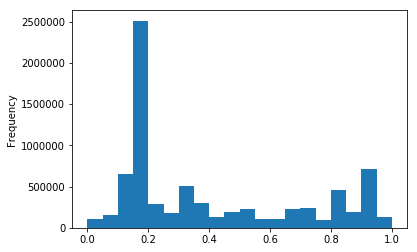

In [46]:
plot_all(df)

### plot one hour of a given day

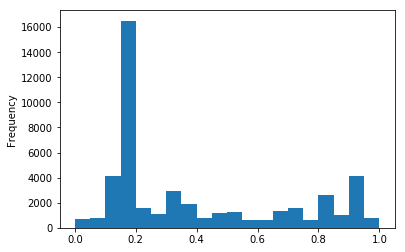

In [47]:
plot_one_hour(df)

### one plot per day, overlayed

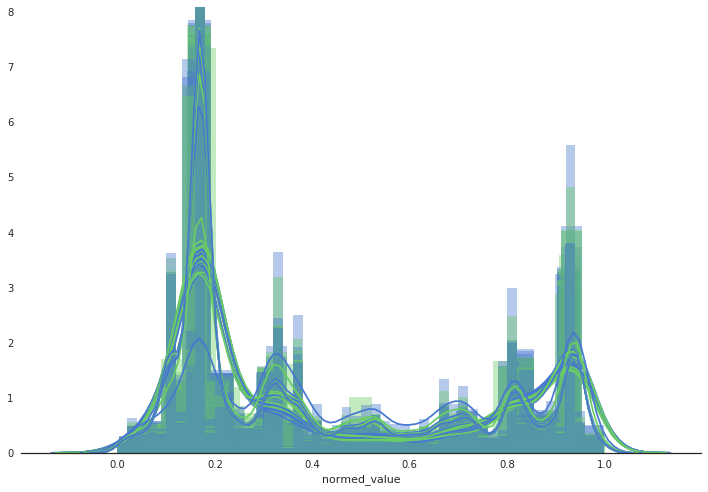

In [48]:
plot_one_per_day_overlay(df)

## distribution of numeric values

In [21]:
sql_prepare = ','.join([create_base_percentile('power_out', 'kwh'),
                        create_number_convert(),
                        create_normalized()])

In [50]:
conn = connect()
df = pd.read_sql(create_normed(sql_prepare), con=conn)

In [52]:
df[:5]

,event_day,event_hour,raw_value,normed_value
0,20170904,0,660,0.337179
1,20170904,0,265,0.130047
2,20170904,0,665,0.339801
3,20170904,0,1670,0.866807
4,20170904,0,146,0.067646


### quantiles

In [53]:
df.quantile(np.linspace(0.0, 1.0, num=11))

,event_hour,raw_value,normed_value
0.0,0.0,17.0,0.000000
0.1,3.0,58.0,0.021500
0.2,6.0,104.0,0.045621
0.3,9.0,159.0,0.074463
0.4,11.0,217.0,0.104877
0.5,13.0,255.0,0.124803
0.6,15.0,255.0,0.124803
0.7,17.0,290.0,0.143157
0.8,19.0,420.0,0.211327
0.9,21.0,643.0,0.328264


### plot all data

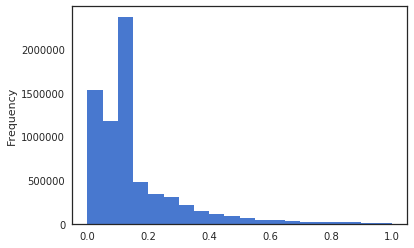

In [54]:
plot_all(df)

### plot one hour of a given day

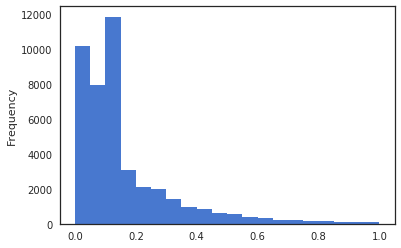

In [55]:
plot_one_hour(df)

### one plot per day, overlayed

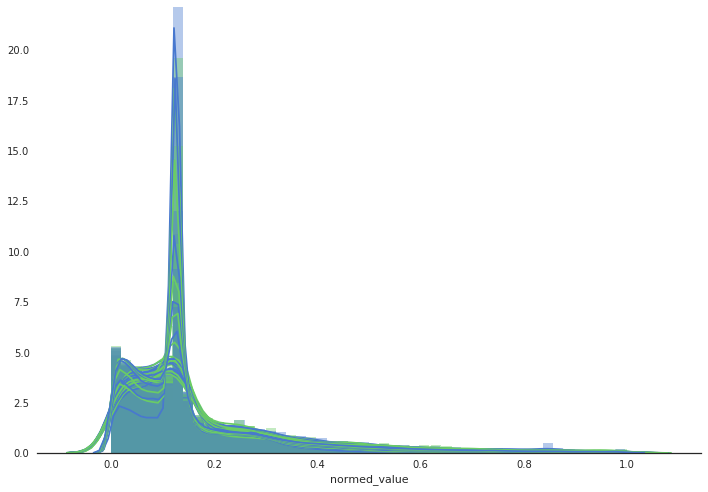

In [56]:
plot_one_per_day_overlay(df)

## distribution of time values

In [22]:
sql_prepare = ','.join([create_base_percentile('power_out', 'first_on_at'),
                        create_time_convert(),
                        create_normalized()])

In [58]:
conn = connect()
df = pd.read_sql(create_normed(sql_prepare), con=conn)

In [60]:
df[:5]

,event_day,event_hour,raw_value,normed_value
0,20170927,5,1506488972,0.000030
1,20170927,5,1506489026,0.000101
2,20170927,5,1506488955,0.000008
3,20170927,5,1506488993,0.000058
4,20170927,5,1506489017,0.000090


### quantiles

In [61]:
df.quantile(np.linspace(0.0, 1.0, num=11))

,event_hour,raw_value,normed_value
0.0,0.0,1.506489e+09,0.000000
0.1,3.0,1.506533e+09,0.057578
0.2,6.0,1.506599e+09,0.145347
0.3,9.0,1.506634e+09,0.190697
0.4,11.0,1.506678e+09,0.249018
0.5,14.0,1.506717e+09,0.300982
0.6,16.0,1.506773e+09,0.374089
0.7,17.0,1.506824e+09,0.441462
0.8,19.0,1.506897e+09,0.537868
0.9,21.0,1.507006e+09,0.681283


### plot all data

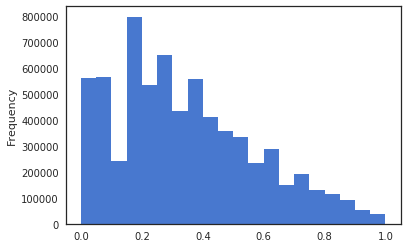

In [62]:
plot_all(df)

### plot one hour of a given day

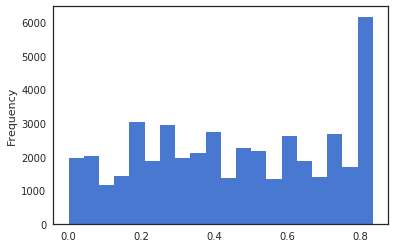

In [63]:
plot_one_hour(df)

### one plot per day, overlayed

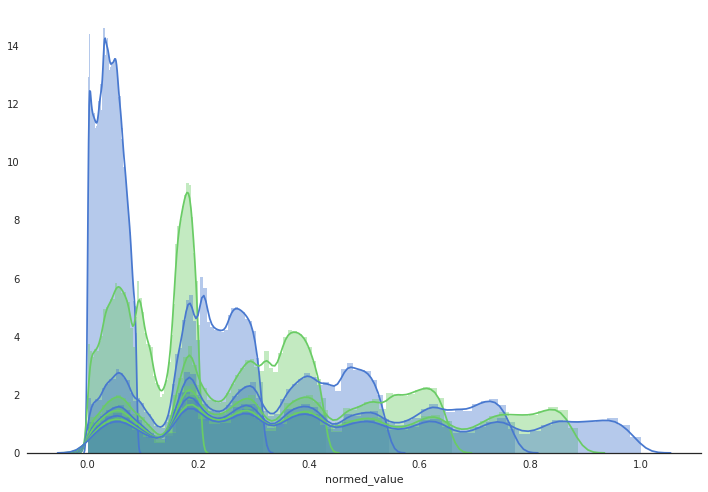

In [64]:
plot_one_per_day_overlay(df)

## distribution of bool values

In [23]:
sql_prepare = ','.join([create_base('power_out', 'generating'),
                        create_bool_convert(),
                        create_normalized()])

In [66]:
conn = connect()
df = pd.read_sql(create_normed(sql_prepare), con=conn)

In [68]:
df[:5]

,event_day,event_hour,raw_value,normed_value
0,20170904,0,0.25,0.0
1,20170904,0,0.25,0.0
2,20170904,0,0.25,0.0
3,20170904,0,0.25,0.0
4,20170904,0,0.25,0.0


### quantiles

In [69]:
df.quantile(np.linspace(0.0, 1.0, num=11))

,event_hour,raw_value,normed_value
0.0,0.0,0.25,0.0
0.1,3.0,0.25,0.0
0.2,6.0,0.25,0.0
0.3,9.0,0.25,0.0
0.4,11.0,0.25,0.0
0.5,13.0,0.25,0.0
0.6,15.0,0.25,0.0
0.7,17.0,0.25,0.0
0.8,19.0,0.25,0.0
0.9,21.0,0.25,0.0


### plot all data

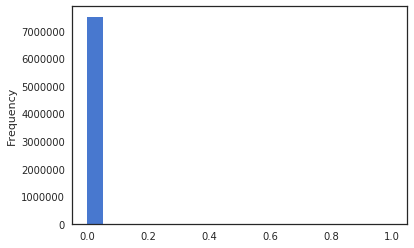

In [70]:
plot_all(df)

### plot one hour of a given day

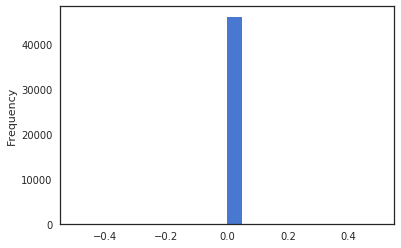

In [72]:
plot_one_hour(df)

### one plot per day, overlayed

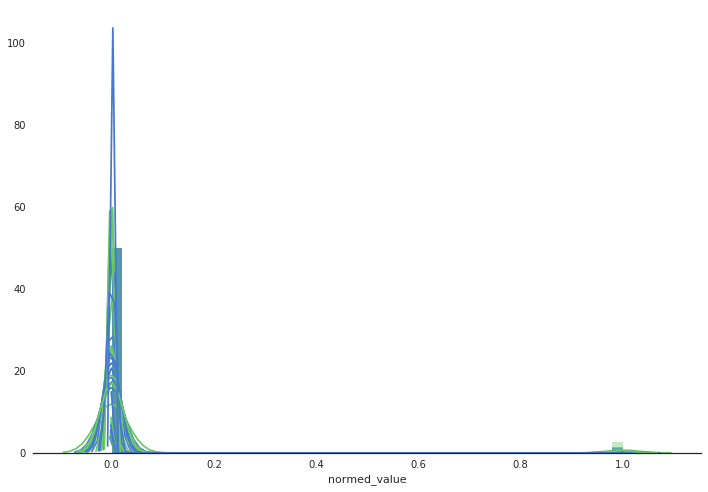

In [73]:
plot_one_per_day_overlay(df)

## distribution of "unique" values

In [24]:
conn = connect()

sql_prepare = ','.join([create_base('power_out', 'mill_signature'),
                        create_string_convert(-8),
                        create_normalized()])

df = pd.read_sql(create_normed(sql_prepare), con=conn)

### quantiles

In [24]:
df.quantile(np.linspace(0.0, 1.0, num=11))

,event_hour,raw_value,normed_value
0.0,0.0,9.694862e+10,0.000000
0.1,3.0,7.047652e+15,0.097805
0.2,6.0,1.432690e+16,0.198825
0.3,9.0,2.161891e+16,0.300022
0.4,11.0,2.863432e+16,0.397380
0.5,13.0,3.584268e+16,0.497417
0.6,15.0,4.288708e+16,0.595178
0.7,17.0,5.002170e+16,0.694191
0.8,19.0,5.747325e+16,0.797602
0.9,21.0,6.464614e+16,0.897146


### plot all data

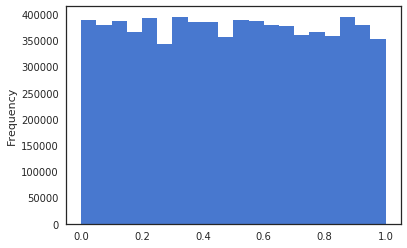

In [25]:
plot_all(df)

### plot one hour of a given day

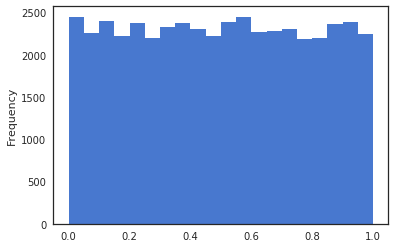

In [26]:
plot_one_hour(df)

### one plot per day, overlayed

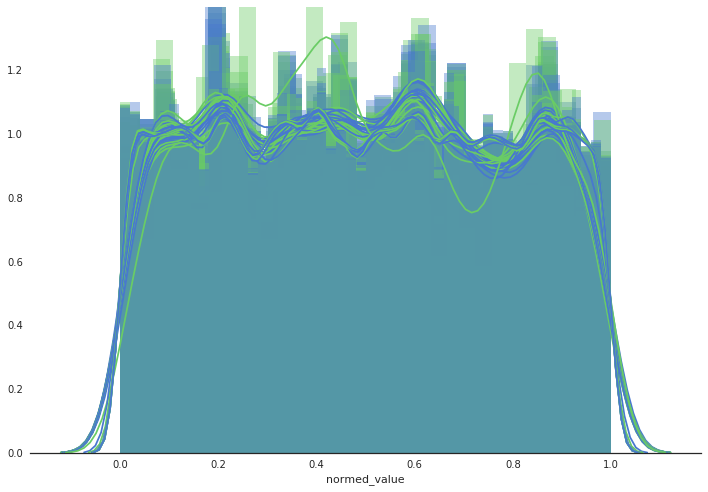

In [27]:
plot_one_per_day_overlay(df)

## distribution of categorial values

In [29]:
conn = connect()

sql_prepare = ','.join([create_base('power_out', 'country'),
                        create_string_convert(),
                        create_normalized()])

df = pd.read_sql(create_normed(sql_prepare), con=conn)

### quantiles

In [34]:
df.quantile(np.linspace(0.0, 1.0, num=21))

,event_hour,raw_value,normed_value
0.00,0.0,5.184839e+13,0.000000
0.05,1.0,4.977339e+15,0.068414
0.10,3.0,7.269088e+15,0.100245
0.15,4.0,1.036419e+16,0.143235
0.20,6.0,1.641676e+16,0.227304
0.25,7.0,1.760655e+16,0.243829
0.30,9.0,2.574811e+16,0.356913
0.35,10.0,3.295785e+16,0.457054
0.40,11.0,3.295785e+16,0.457054
0.45,12.0,3.295785e+16,0.457054


### plot all data

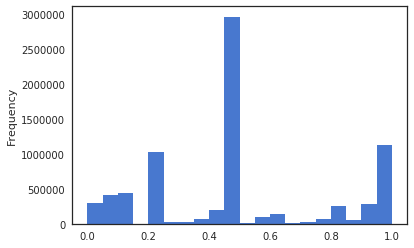

In [31]:
plot_all(df)

### plot one hour of a given day

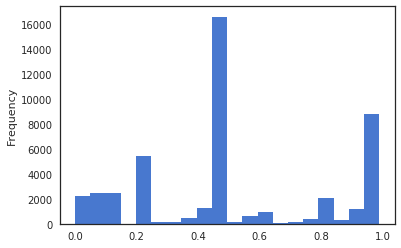

In [32]:
plot_one_hour(df)

### one plot per day, overlayed

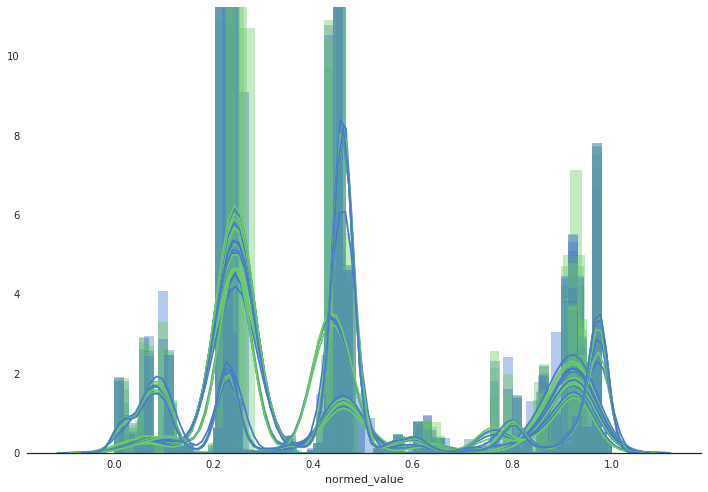

In [33]:
plot_one_per_day_overlay(df)